In [160]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 28
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange
import scipy.stats
import itertools
import pyfftw

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [161]:
# @njit
def compute_second_moment(a_k, k0, N):

    dx       = np.pi / N 
    kx       = np.arange(N + 1)
    kx[:k0]  = 0.0
    sec_mmnt = np.zeros((N))

    for i in range(1, N + 1):
        sec_mmnt[i - 1] = np.sum(a_k * (1.0 - np.cos( i * dx * kx)))

    return sec_mmnt * (2 / N)


In [179]:
def compute_grad(u_z, kmin, kmax):
    print("\nCreating Gradient\n")
    k            = np.concatenate((np.zeros((kmin)), np.arange(kmin, kmax + 1), -np.flip(np.arange(kmin, kmax)), np.zeros((kmin - 1))))
    print(k)
    grad_u_z     = np.complex(0.0, 1.0) * k * u_z
    du_x         = np.real(np.fft.ifft(grad_u_z, axis = 1))
    du_x_rms_tmp = np.sqrt(np.mean(du_x ** 2, axis = 1))
    du_x_rms     = np.array([du_x[i, :] / du_x_rms_tmp[i] for i in range(u_z.shape[0])])

    return du_x , du_x_rms

In [172]:
def compute_modes_real_space(amps, phases, N):
    print("\n...Creating Real Space Soln...\n")

    # Create full set of amps and phases
    amps_full   = np.append(amps[:], np.flipud(amps[1:-1]))
    phases_full = np.concatenate((phases[:, :], -np.fliplr(phases[:, 1:-1])), axis = 1)

    # Construct modes and realspace soln
    u_z = amps_full * np.exp(np.complex(0.0, 1.0) * phases_full)
    u   = np.real(np.fft.ifft(u_z, axis = 1))

    return u, u_z

@njit
def compute_rms(u):
    
    # Compute normalized realspace soln
    u_urms = np.zeros((u.shape[0], u.shape[1]))
    u_rms  = np.zeros((u.shape[0]))
    
    for i in range(u.shape[0]):    
        u_rms[i]     = np.sqrt(np.mean(u[i, :]**2))
        u_urms[i, :] = u[i, :] / u_rms[i] 
    
    return u_rms, u_urms

In [144]:
u_rms, u_urms = compute_rms(u1)

In [130]:
amps_full   = np.append(amps[:], np.flipud(amps[1:-1]))
phases_full = np.concatenate((phi[:, :], -np.fliplr(phi[:, 1:-1])), axis = 1)
u_z         = amps_full * np.exp(np.complex(0.0, 1.0) * phases_full)
u1 = np.real(np.fft.ifft(u_z, axis = 1))

ifft_object = pyfftw.builders.ifft(u_z, axis = 1)
print(u_z.shape)


(100000, 256)


In [173]:
u, u_z = compute_modes_real_space(amps, phi, N)


...Creating Real Space Soln...



In [180]:
u_grad, u_grad_rms = compute_grad(u_z, kmin, kmax)


Creating Gradient

[  0.   0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.
  -4.  -3.  -2.   0.]


In [181]:
print(u[:5,:5])
print(u_z[:5,:5])

print(u_grad[:5, :5])
print(u_grad_rms[:5, :5])


[[ 0.01291813  0.02774035  0.03604304  0.02466386 -0.01145377]
 [ 0.01319727  0.0273702   0.03554656  0.02666054 -0.00952602]
 [ 0.01350029  0.02724711  0.03483836  0.02839881 -0.00733828]
 [ 0.01377999  0.02730652  0.03402566  0.02985904 -0.00496785]
 [ 0.01403367  0.02745073  0.03319426  0.03106977 -0.00248872]]
[[ 0.        +0.j          0.        +0.j          0.44757284-0.22288687j
  -0.32584592-0.07025345j  0.24809041-0.03084072j]
 [ 0.        +0.j          0.        +0.j          0.44545173-0.22709637j
  -0.32623361-0.06843055j  0.24656638-0.04129192j]
 [ 0.        +0.j          0.        +0.j          0.44320761-0.2314455j
  -0.3265469 -0.06691961j  0.24465196-0.05143361j]
 [ 0.        +0.j          0.        +0.j          0.44082476-0.2359524j
  -0.32676316-0.06585553j  0.24240741-0.06114448j]
 [ 0.        +0.j          0.        +0.j          0.43828722-0.24063315j
  -0.3268635 -0.06535565j  0.23990068-0.07033962j]]
[[ 0.05943603  0.0671129   0.00894068 -0.13960206 -0.1456110

In [129]:
%%timeit
u1 = np.real(np.fft.ifft(u_z, axis = 1))

391 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
%%timeit
u2 = np.real(ifft_object(u_z))

211 ms ± 4.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
u1 = np.real(np.fft.ifft(u_z, axis = 1))
u2 = np.real(ifft_object(u_z))
print(np.allclose(u1, u2))
print(u1.shape)
print(u2.shape)
print(u1[:5, :5])
print(u2[:5, :5])

True
(100000, 256)
(100000, 256)
[[0.00671827 0.00632674 0.00725574 0.0065727  0.00618747]
 [0.00676016 0.00637061 0.00728078 0.00658767 0.00616107]
 [0.006804   0.00641805 0.00730297 0.0065965  0.00614201]
 [0.00684929 0.00646811 0.00732338 0.00659775 0.00613196]
 [0.00689554 0.00651952 0.00734298 0.00659085 0.00613178]]
[[0.00671827 0.00632674 0.00725574 0.0065727  0.00618747]
 [0.00676016 0.00637061 0.00728078 0.00658767 0.00616107]
 [0.006804   0.00641805 0.00730297 0.0065965  0.00614201]
 [0.00684929 0.00646811 0.00732338 0.00659775 0.00613196]
 [0.00689554 0.00651952 0.00734298 0.00659085 0.00613178]]


In [100]:
%%timeit
for i in range(phi.shape[0]):
    amps_full   = np.append(amps[:], np.flipud(amps[1:-1]))
    phases_full = np.append(phi[i, :], -np.flipud(phi[i, 1:-1]))
    u_z         = amps_full * np.exp(np.complex(0.0, 1.0) * phases_full)
    u1 = np.real(np.fft.ifft(u_z))

5.22 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%%timeit
for i in range(phi.shape[0]):
    amps_full   = np.append(amps[:], np.flipud(amps[1:-1]))
    phases_full = np.append(phi[i, :], -np.flipud(phi[i, 1:-1]))
    u_z         = amps_full * np.exp(np.complex(0.0, 1.0) * phases_full)
    u2 = np.real(ifft_object(u_z))

4.99 s ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
u1 = np.real(np.fft.ifft(u_z))
u2 = np.real(ifft_object(u_z))
print(u2)

[ 6.71827168e-03  6.32673591e-03  7.25574259e-03  6.57270396e-03
  6.18746592e-03  3.98479971e-03 -3.31277285e-03 -3.62868241e-03
 -6.65777766e-03 -7.87597700e-03 -7.43130150e-03 -7.62575280e-03
 -7.34528274e-03 -5.15658261e-03 -4.68972116e-03 -3.04698787e-03
 -5.58826532e-03 -6.21857697e-03 -6.31653538e-03 -6.21332965e-03
 -6.04398737e-03 -4.54285855e-03 -5.02382457e-03 -6.35109074e-03
 -7.04651900e-03 -7.47896094e-03 -7.29049649e-03 -4.64000912e-03
 -3.14162876e-03 -2.53348842e-03 -1.77442994e-03 -1.00340572e-04
 -1.27627042e-04  8.23314278e-04  5.66304718e-04  8.46912115e-04
  1.10667158e-03  9.56761030e-04  2.06409461e-03  2.26230918e-03
  8.69765126e-04  1.75405061e-03  2.19882723e-03  1.69249743e-03
  1.77559432e-03  8.10989347e-04  1.27216080e-03 -2.43517917e-03
 -4.63715332e-03 -5.48645729e-03 -4.05208296e-03 -2.01516710e-03
 -1.13154721e-03 -1.29306866e-03 -2.91179774e-03 -2.51497233e-03
 -1.80208864e-03 -4.26120442e-04  1.29086985e-04 -8.79408163e-04
 -9.34236590e-04 -8.32092

In [159]:
amps_full   = np.append(amps[:], np.flipud(amps[1:-1]))
phases_full = np.append(phi[0, :], -np.flipud(phi[0, 1:-1]))
u_z         = amps_full * np.exp(np.complex(0.0, 1.0) * phases_full)
u1 = np.real(np.fft.ifft(u_z))

k            = np.concatenate((np.zeros((kmin)), np.arange(kmin, kmax + 1), -np.flip(np.arange(kmin, kmax)), np.zeros((kmin - 1))))
grad_u_z     = np.complex(0.0, 1.0) * k * u_z
u_grad       = np.real(np.fft.ifft(grad_u_z))

print(u1)
print(u_grad)

[ 0.01291813  0.02774035  0.03604304  0.02466386 -0.01145377  0.01020986
  0.06096589 -0.02250596 -0.0403806  -0.04458713 -0.04289768 -0.03525941
 -0.02821348 -0.01968734  0.00897421  0.04115371  0.05553631  0.06610415
  0.05417668  0.02512966 -0.0506571  -0.04010819 -0.04202787 -0.00083864
  0.02380388 -0.01786454 -0.02265301 -0.0199686  -0.01528489 -0.01156664
  0.00619123  0.01234389]
[ 5.94360288e-02  6.71128971e-02  8.94067671e-03 -1.39602055e-01
 -1.45611080e-01  3.77860865e-01 -1.13389401e-01 -4.30267098e-01
  1.13610686e-01 -1.23294754e-01  1.23992883e-01 -4.34594006e-02
  1.09193578e-01  3.36691348e-03  2.71629534e-01  2.65167826e-02
  1.53501871e-01 -8.91846337e-02  1.06073591e-02 -3.99093131e-01
 -1.60420740e-01  8.47802810e-02  1.57802871e-02  3.20375263e-01
 -1.32172200e-01 -1.53938456e-01  4.13381293e-02  1.18105094e-04
  3.12758235e-02  3.65869617e-02  1.05738383e-01 -3.13303595e-02]


In [ ]:
# @jit(nopython = True)
def compute_vel_inc(u, rlen):

    # rList  = [int(r) for r in np.arange(1, kmax + 1, kmax/rlen)]
    rList  = [1, kmax]
    du_r   = np.zeros((u.shape[0], u.shape[1], rlen))

    for r_indx, r in enumerate(rList):
        for i in range(u.shape[0]):
            for j in range(u.shape[1]):
                    du_r[i, j, r_indx] = u[i, np.mod(j + r, u.shape[1])] - u[i, j]

    return du_r, rList

In [ ]:
# @jit(nopython = True)
def compute_str_p(du_r, rlen):
pList = [2, 3, 4, 5, 6]

str_p     = np.zeros((len(pList), rlen))
str_p_abs = np.zeros((len(pList), rlen))

for r in range(rlen):
    for i, p in enumerate(pList):
        p_du_r          = du_r[:, :, r]**p
        str_p[i, r]     = np.mean(p_du_r.flatten())
        str_p_abs[i, r] = np.absolute(np.mean(p_du_r.flatten()))

return str_p, str_p_abs

In [164]:
#########################
##  Get Input Parameters
#########################
k0    = 1
alpha = 1.0
beta  = 0.0
iters = 10
trans = 1000
N     = 32
u0    = "RANDOM"

kmin = k0 + 1
kmax = int(N / 2)

filename = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(N, k0, alpha, beta, u0, iters, trans)


######################
##  Input & Output Dir
######################
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Stats"


In [165]:
HDFfileData = h5py.File(input_dir + filename + '.h5', 'r')

# print input file name to screen
print("\n\nData File: %s.h5\n" % filename)



Data File: /RESULTS_N[32]_k0[1]_ALPHA[1.000]_BETA[0.000]_u0[RANDOM]/SolverData_ITERS[10]_TRANS[1000].h5



In [166]:
# Read Velocity Incrments
vel_inc_bincounts = np.zeros((2, 1000))
vel_inc_binedges  = np.zeros((2, 1001))
for i in range(2):
    vel_inc_bincounts[i, :] = HDFfileData["VelInc[{}]_BinCounts".format(i)][:]
    vel_inc_binedges[i, :] = HDFfileData["VelInc[{}]_BinEdges".format(i)][:]
grad_bincounts = HDFfileData["VelGrad_BinCounts"][:]
grad_binedges  = HDFfileData["VelGrad_BinEdges"][:]

vel_inc_stats = HDFfileData["VelIncStats"][:, :]

# Read In Triad Stats
Triad_Cent_R   = HDFfileData["TriadCentroid_R"]
Triad_Cent_Phi = HDFfileData["TriadCentroid_Phi"]

# Read Amps and Structure Functions
amps     = HDFfileData["Amps"][:]
str_func = HDFfileData["StructureFuncs"][:, :]

phi = HDFfileData["Phases"][:, :]

# Close file when done
HDFfileData.close()

In [ ]:
## Plot Histogram of Vel Incrments
plt.figure()
for i in range(2):
    bin_centers = (vel_inc_binedges[i, 1:] + vel_inc_binedges[i, :-1]) * 0.5
    bin_width   = vel_inc_binedges[i, 1] - vel_inc_binedges[i, 0]
    num_obs     = N * iters
    plt.plot(bin_centers, vel_inc_bincounts[i] / (num_obs * bin_width))
# bin_centers = (grad_binedges[1:] + grad_binedges[:-1]) * 0.5
# plt.plot(bin_centers, grad_bincounts)
plt.legend([r"Smallest", r"Largest", r"Gradient"])
plt.yscale('symlog')
plt.grid(True)

plt.show()
# plt.savefig(output_dir + "/PDF_Vel_Incrments_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]_ITERS[{}]_TRANS[{}].png".format(N, k0, alpha, beta, u0, iters, trans), format='png', dpi = 400)  
# plt.close()

In [ ]:
## Plot triad centroid 
fig = plt.figure(figsize = (16, 9), tight_layout = True)
gs  = GridSpec(1, 1)

myjet   = cm.jet(np.arange(255))
norm    = mpl.colors.Normalize(vmin = 0.0, vmax = 1.0)
my_mjet = mpl.colors.LinearSegmentedColormap.from_list('my_map', myjet, N = kmax) # set N to inertial range
my_m.set_under('1.0')
m       = cm.ScalarMappable( norm = norm, cmap = my_mjet)     

ax4  = fig.add_subplot(gs[0, 0])
im   = ax4.imshow(np.transpose(Triad_Cent_R), cmap = my_mjet, norm = norm)
kMax = kmax - kmin # Adjusted indices in triads matrix
kMin = kmin - kmin # Adjusted indices in triads matrix
ax4.set_xticks([kmin, int((kMax - kMin)/5), int(2 * (kMax - kMin)/5), int(3* (kMax - kMin)/5), int(4 * (kMax - kMin)/5), kMax])
ax4.set_xticklabels([kmin, int((kmax - kmin)/5), int(2 * (kmax - kmin)/5), int(3* (kmax - kmin)/5), int(4 * (kmax - kmin)/5), kmax])
ax4.set_yticks([kMin, int((kMax / 2 - kMin)/4), int(2 * (kMax / 2 - kMin)/4), int(3* (kMax / 2 - kMin)/4),  int((kmax)/ 2 - kmin)])
ax4.set_yticklabels([kmin + kmin, int((kmax / 2 - kmin)/4) + kmin, int(2 * (kmax / 2 - kmin)/4) + kmin, int(3* (kmax / 2 - kmin)/4) + kmin,  int(kmax / 2)])
ax4.set_xlabel(r'$k_3$', labelpad = 0)
ax4.set_ylabel(r'$k_1$',  rotation = 0, labelpad = 10)
ax4.set_xlim(left = kmin - 0.5)
ax4.set_ylim(bottom = int((kmax)/ 2 - kmin) + 0.5)
div4  = make_axes_locatable(ax4)
cax4  = div4.append_axes('right', size = '5%', pad = 0.1)
cbar4 = plt.colorbar(im, cax = cax4, orientation='vertical')
cbar4.set_ticks([ 0.0, 0.5, 1])
cbar4.set_ticklabels([r"$0$", r"$0.5$", r"$1$"])

plt.show()
# plt.savefig(output_dir + "/Triad_Centroid_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]_ITERS[{}]_TRANS[{}].png".format(N, k0, alpha, beta, u0, iters, trans), format='png', dpi = 400)  
# plt.close()

In [36]:
amps = np.arange(0.0, n + 1)
amps[1:] = 1/(amps[1:]**(alpha))
n = int(N / 2)
dx           = np.pi / n 
kx           = np.arange(n + 1)
kx[:k0 + 1]  = 0.0
sec_mmnt = np.zeros((n))

for i in range(1, n + 1):
    sec_mmnt[i - 1] = np.sum(amps * (1.0 - np.cos( i * dx * kx)))
    
print(sec_mmnt)

[0.         1.         0.5        0.33333333 0.25       0.2
 0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909
 0.08333333 0.07692308 0.07142857 0.06666667 0.0625     0.05882353
 0.05555556 0.05263158 0.05       0.04761905 0.04545455 0.04347826
 0.04166667 0.04       0.03846154 0.03703704 0.03571429 0.03448276
 0.03333333 0.03225806 0.03125    0.03030303 0.02941176 0.02857143
 0.02777778 0.02702703 0.02631579 0.02564103 0.025      0.02439024
 0.02380952 0.02325581 0.02272727 0.02222222 0.02173913 0.0212766
 0.02083333 0.02040816 0.02       0.01960784 0.01923077 0.01886792
 0.01851852 0.01818182 0.01785714 0.01754386 0.01724138 0.01694915
 0.01666667 0.01639344 0.01612903 0.01587302 0.015625   0.01538462
 0.01515152 0.01492537 0.01470588 0.01449275 0.01428571 0.01408451
 0.01388889 0.01369863 0.01351351 0.01333333 0.01315789 0.01298701
 0.01282051 0.01265823 0.0125     0.01234568 0.01219512 0.01204819
 0.01190476 0.01176471 0.01162791 0.01149425 0.01136364 0.01123596
 0.

[0.02587115 0.03806794 0.04398132 0.04858031 0.05198557 0.05476167
 0.05715097 0.05909584 0.06092811 0.06239153 0.06386792 0.06501369
 0.06624035 0.06715841 0.06819825 0.06894336 0.06983682 0.07044489
 0.07121958 0.0717155  0.07239116 0.07279294 0.07338424 0.0737054
 0.07422359 0.0744746  0.07492855 0.07511771 0.07551458 0.07564866
 0.07599435 0.07607893 0.07637841 0.07641824 0.07667574 0.07667488
 0.0768941  0.07685611 0.07704029 0.07696831 0.07712035 0.0770172
 0.07713974 0.07700797 0.0771034  0.07694537 0.07701589 0.07683376
 0.07688145 0.07667724 0.07670402 0.07647963 0.07648733 0.07624456
 0.07623491 0.07597547 0.07595012 0.07567564 0.07563617 0.07534821
 0.07529614 0.07499622 0.07493302 0.07462258 0.07454966 0.07423011
 0.07414885 0.07382153 0.07373326 0.0733995  0.0733055  0.07296657
 0.07286809 0.07252523 0.07242348 0.07207789 0.07197404 0.07162688
 0.07152208 0.07117447 0.07106982 0.07072285 0.07061941 0.07027413
 0.07017294 0.06983036 0.0697324  0.06939351 0.06929974 0.068965

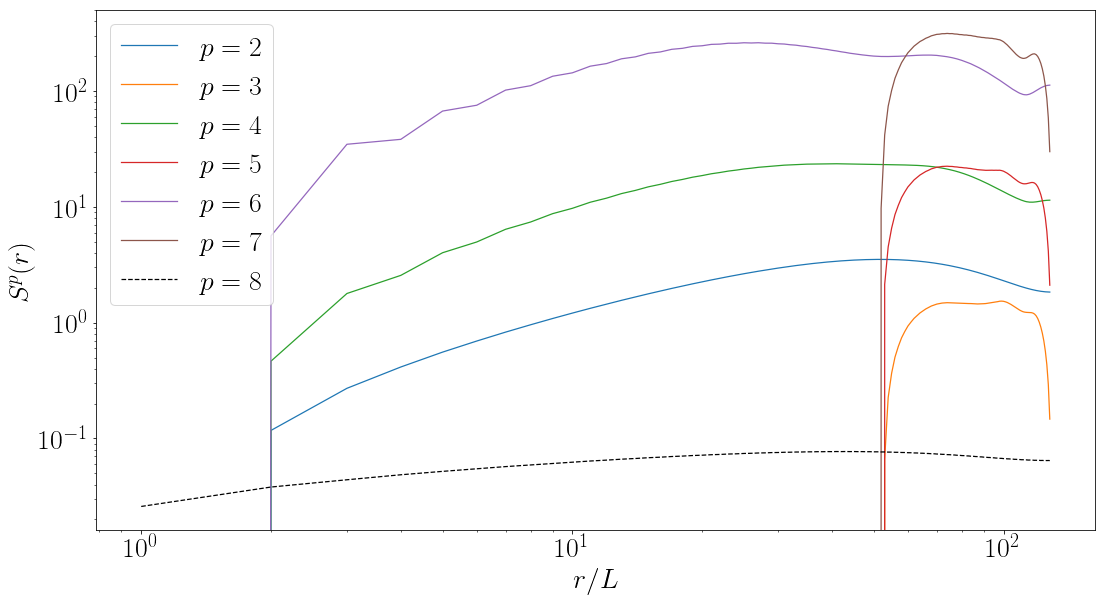

In [62]:
## Plot structure functions
r = np.arange(1, N/2 + 1)

second_moment = compute_second_moment(amps, k0, int(N/2))
print(second_moment)
fig = plt.figure(figsize = (16, 9), tight_layout = True)
gs  = GridSpec(1, 1)
ax  = fig.add_subplot(gs[0, 0])
for i in range(str_func.shape[0]):
    ax.plot(r, str_func[i, :])
ax.plot(r, second_moment[:], 'k--')
ax.legend([r"$p = {}$".format(p) for p in range(2, 8 + 1)])
ax.set_yscale('Log')
ax.set_xscale('Log')
ax.set_xlabel(r"$r / L$")
ax.set_ylabel(r"$S^{p}(r)$")

plt.show()
# plt.savefig(output_dir + "/Structure_Funcs_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]_ITERS[{}]_TRANS[{}].png".format(N, k0, alpha, beta, u0, iters, trans), format='png', dpi = 400)  
# plt.close()

In [42]:
vel_inc_stats

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])